# **Práctica Final: Clasificación con Scikit-learn y MLflow**

In [29]:
!pip install scikit-learn mlflow

Importamos las librerías necesarias que vamos a utilizar. En este caso cargaremos un dataset de Scikit-learn de clasificación de texto como es fetch_20newsgroups.

In [30]:
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

## Análisis de Datos con Scikit-Learn

In [31]:
categories = ['sci.space', 'rec.sport.baseball'] #Definimos las dos clases que queremos clasificar

newsgroups = fetch_20newsgroups( #Descargamos el dataset filtrado por esas categorias
    subset='all',
    categories=categories,
    shuffle=True,
    random_state=42
)

X = newsgroups.data
y = newsgroups.target
target_names = newsgroups.target_names

print("Número de documentos:", len(X))
print("Clases:", target_names)

print("\nEjemplo de texto:\n")
print(X[0][:800]) #Imprimimos los primeros 800 caracteres del primer documento para ver cómo es el texto real.
print("\nEtiqueta:", y[0], "->", target_names[y[0]])


Número de documentos: 1981
Clases: ['rec.sport.baseball', 'sci.space']

Ejemplo de texto:

From: mss@netcom.com (Mark Singer)
Subject: Re: Young Catchers
Article-I.D.: netcom.mssC52qMx.768
Organization: Netcom Online Communications Services (408-241-9760 login: guest)
Lines: 86

In article <7975@blue.cis.pitt.edu> genetic+@pitt.edu (David M. Tate) writes:
>mss@netcom.com (Mark Singer) said:
>>
>>We know that very, very few players at this age make much of an impact
>>in the bigs, especially when they haven't even played AAA ball.  
>
>Yes.  But this is *irrelevant*.  You're talking about averages, when we
>have lots of information about THIS PLAYER IN PARTICULAR to base our
>decisions on.

Do you really have *that* much information on him?  Really?

>Why isn't Lopez likely to hit that well?  He hit that well last year (after
>adjusting his stats for park and league and such); he

Etiqueta: 0 -> rec.sport.baseball


In [32]:
df = pd.DataFrame({ #Creamos un DataFrame con el texto, la etiqueta numérica y el nombre de la clase
    "text": X,
    "label": y,
    "label_name": [target_names[i] for i in y]
})

In [33]:
df.head() #Mostramos las primeras filas

,text,label,label_name
0,From: mss@netcom.com (Mark Singer)\nSubject: R...,0,rec.sport.baseball
1,From: cuz@chaos.cs.brandeis.edu (Cousin It)\nS...,0,rec.sport.baseball
2,From: J019800@LMSC5.IS.LMSC.LOCKHEED.COM\nSubj...,0,rec.sport.baseball
3,From: tedward@cs.cornell.edu (Edward [Ted] Fis...,0,rec.sport.baseball
4,From: snichols@adobe.com (Sherri Nichols)\nSub...,0,rec.sport.baseball


In [34]:
df["label_name"].value_counts() #Contamos cuántos ejemplos hay de cada clase, así también nos servirá para ver si el dataset está balanceado

label_name
rec.sport.baseball    994
sci.space             987
Name: count, dtype: int64

En este caso vemos que el dataset estaría bastante balanceado y óptimo para el entrenamiento.

## División Train/Test

Primero antes de preprocesar y entrenar, dividimos los datos en un 80% de train y un 20% de test. 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y #Con stratify aseguramos que ambas clases mantengan la misma proporción en train y test
)

## Preprocesamiento de texto

El siguiente paso será crear un pipeline con pasos secuenciales y hacer una vectorización con TF-IDF, para después utilizar un clasificador como LogisticRegression.

In [36]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english", #Eliminamos palabras muy comunes
        max_df=0.7 #Eliminamos palabras que aparecen más del 70% de documentos para quitar ruido
    )),
    ("clf", LogisticRegression(
        max_iter=1000, #Aseguramos convergencia
        n_jobs=-1 #Usamos todos los núcleos disponibles
    ))
])

## Entrenamiento de un Modelo con Scikit-Learn

In [37]:
pipeline.fit(X_train, y_train),
y_pred = pipeline.predict(X_test)

## Evaluación del Modelo y Obtención de Parámetros

In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred)),
print("Precision:", precision_score(y_test, y_pred)),
print("Recall:", recall_score(y_test, y_pred)),
print("\nClassification report:\n"),
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy: 0.9899244332493703
Precision: 0.9948979591836735
Recall: 0.9848484848484849

Classification report:

                    precision    recall  f1-score   support

rec.sport.baseball       0.99      0.99      0.99       199
         sci.space       0.99      0.98      0.99       198

          accuracy                           0.99       397
         macro avg       0.99      0.99      0.99       397
      weighted avg       0.99      0.99      0.99       397



El modelo muestra un rendimiento excelente, con casi un 99% de acierto y métricas muy equilibradas entre ambas clases. Esto indica que la combinación TF‑IDF + Logistic Regression funciona de forma muy sólida en este problema.

## Registro de métricas con MLflow

In [39]:
mlflow.set_experiment("text_classification_20newsgroups")
with mlflow.start_run(run_name="logreg_tfidf_base"):

    # Guardamos hiperparámetros del modelo
    mlflow.log_param("vectorizer_stop_words", "english")
    mlflow.log_param("vectorizer_max_df", 0.7)
    mlflow.log_param("clf_type", "LogisticRegression")
    mlflow.log_param("clf_max_iter", 1000)

    # Entrenamiento
    pipeline.fit(X_train, y_train)

    # Predicción
    y_pred = pipeline.predict(X_test)

    # Guardamos las métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)

    # Guardamos el modelo
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)

2026/01/30 09:21:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/01/30 09:21:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/01/30 09:21:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/01/30 09:21:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/01/30 09:21:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/01/30 09:21:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/01/30 09:21:44 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/30 09:21:44 INFO mlflow.store.db.utils: Updating database tables
2026/01/30 09:21:44 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/30 09:21:44 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/30 09:21:44 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/30 09:2

Accuracy: 0.9899244332493703
Precision: 0.9948979591836735
Recall: 0.9848484848484849


Luego crearemos una función para poder lanzar varios experimentos.

In [40]:
def run_experiment(max_df=0.7, ngram_range=(1,1), clf="logreg"):
    with mlflow.start_run(run_name=f"{clf}_maxdf{max_df}_ng{ngram_range}"):

        if clf == "logreg":
            classifier = LogisticRegression(max_iter=1000, n_jobs=-1)
        else:
            from sklearn.svm import LinearSVC
            classifier = LinearSVC()

        pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(
                stop_words="english",
                max_df=max_df,
                ngram_range=ngram_range
            )),
            ("clf", classifier)
        ])

        mlflow.log_param("max_df", max_df)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("clf", clf)

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)

        mlflow.sklearn.log_model(pipeline, artifact_path="model")

        print(f"[{clf}] max_df={max_df}, ngram={ngram_range} -> acc={acc:.4f}")

Vamos a ejecutar varios experimentos para comprobar que funciona correctamente.

In [41]:
run_experiment(max_df=0.7, ngram_range=(1,1), clf="logreg")
run_experiment(max_df=0.9, ngram_range=(1,2), clf="logreg")
run_experiment(max_df=0.7, ngram_range=(1,2), clf="svm")


2026/01/30 09:24:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[logreg] max_df=0.7, ngram=(1, 1) -> acc=0.9899


2026/01/30 09:24:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[logreg] max_df=0.9, ngram=(1, 2) -> acc=0.9874


2026/01/30 09:24:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[svm] max_df=0.7, ngram=(1, 2) -> acc=0.9924


## Visualización en MLflow

A continuación se muestran las capturas de la interfaz de MLflow, donde se registran los diferentes experimentos realizados. Se incluyen:

· La tabla de runs con las métricas principales:

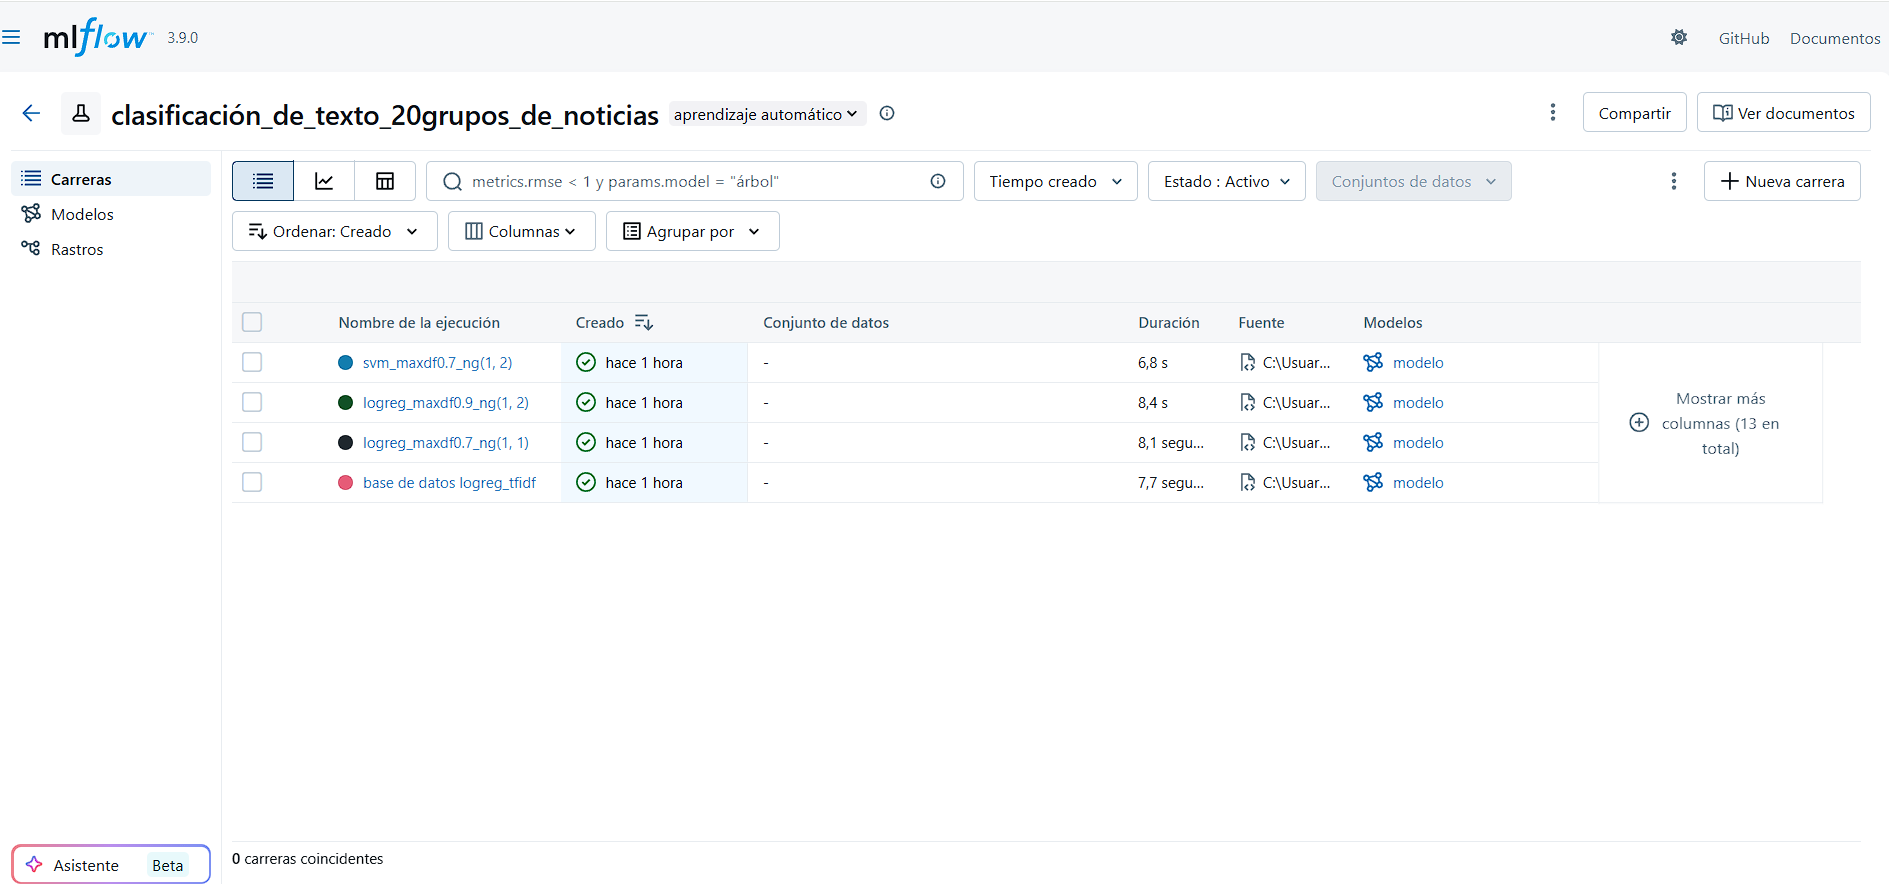

· El detalle de un run con parámetros y métricas:

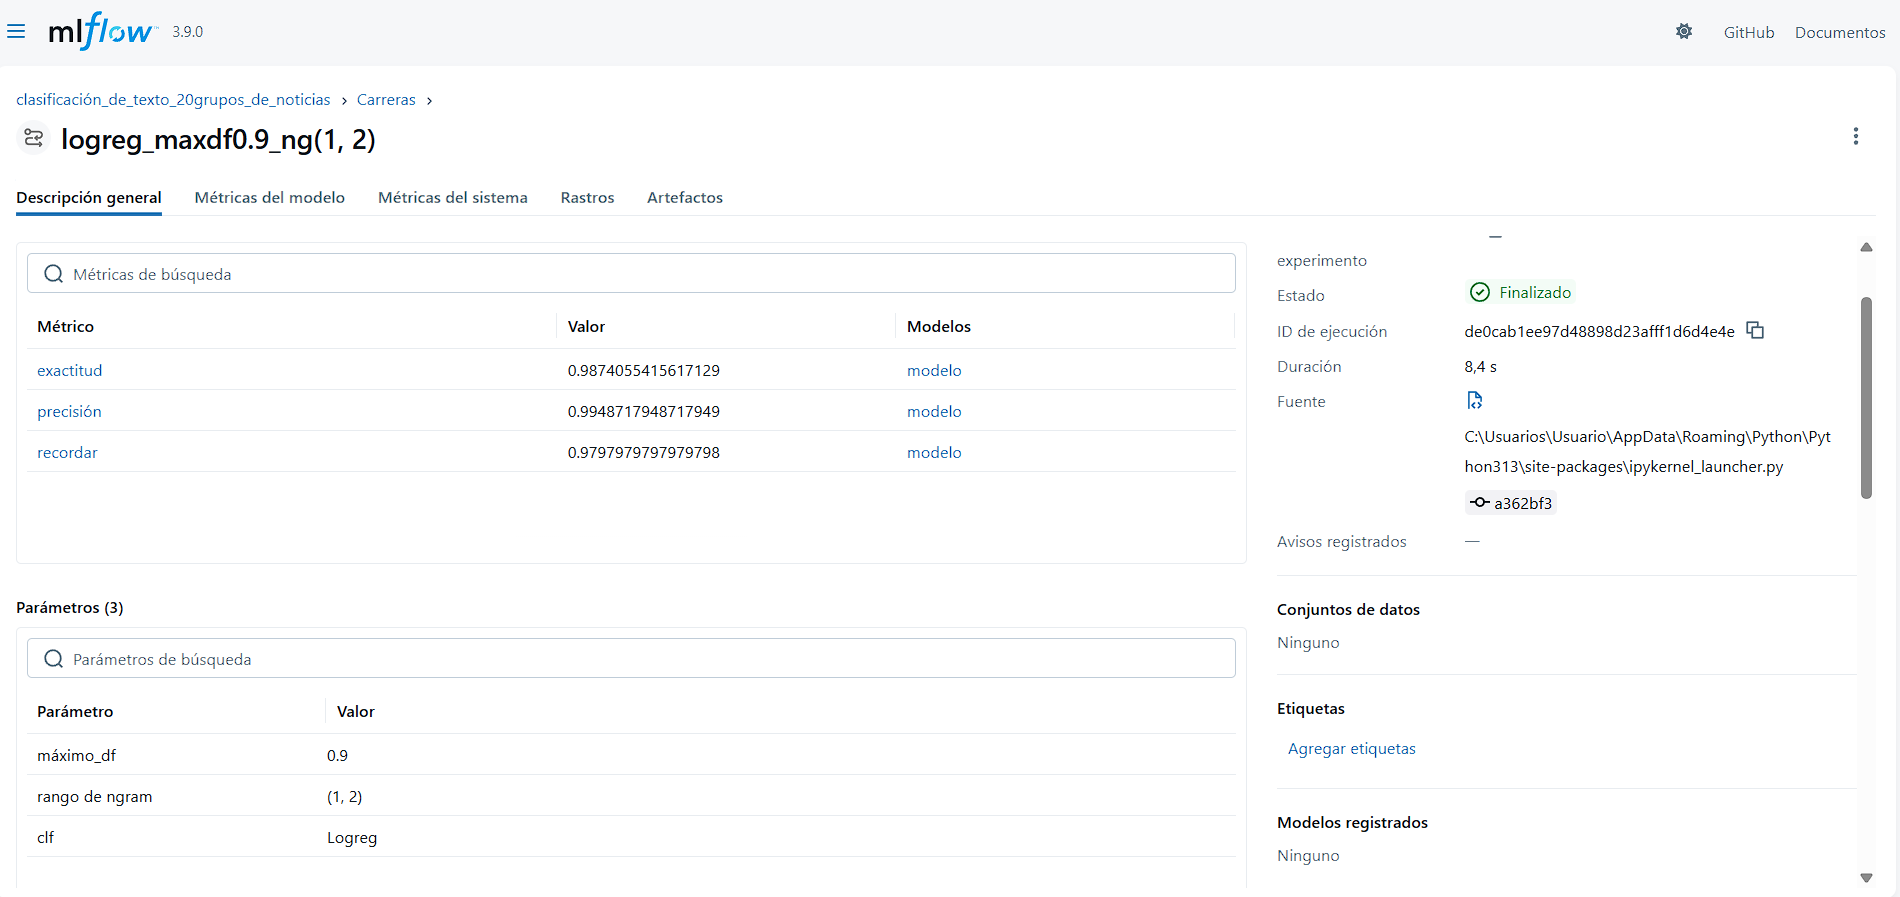

· Una comparación entre varios runs para analizar el impacto de los hiperparámetros.
Estas capturas demuestran el uso de MLflow para el seguimiento, gestión y comparación de experimentos de Machine Learning.

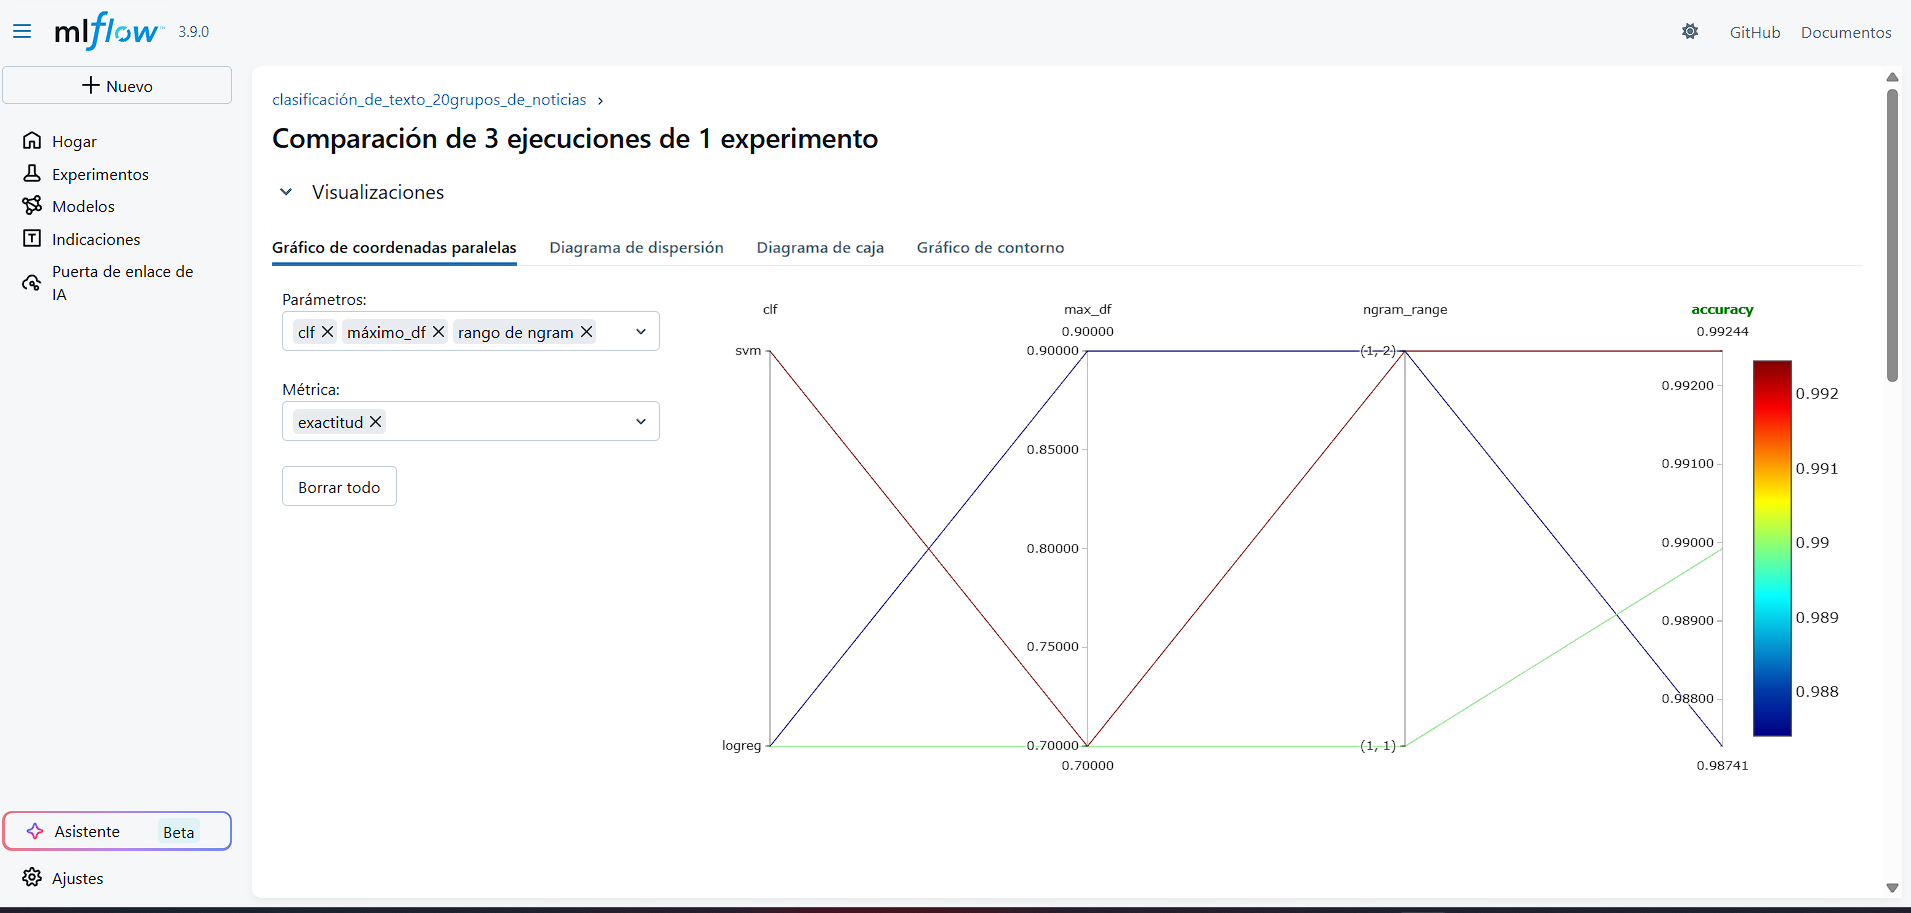

## Ejecución desde scripts

Para estructurar el proyecto de forma profesional, se han creado dos archivos:

- functions.py: contiene las funciones de carga de datos, entrenamiento, evaluación y registro en MLflow.

- main.py: permite ejecutar experimentos desde terminal utilizando argumentos de entrada (--max_df, --clf_type, etc.).